In [1]:
from google.colab import drive # loads a library to mount your google drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Annotations of the input data images are displayed either 5 random images from the data can be displayed or a single image directly with its name

In [2]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import numpy as np
from pycocotools.coco import COCO
from skimage.measure import find_contours
from PIL import Image
import colorsys

# Paths to the folders and annotation file
train_folder = '/content/drive/MyDrive/Trash_Can/train'
annotation_file = '/content/drive/MyDrive/Trash_Can/annotations/instances_train_trashcan.json'

# Load COCO annotations
coco = COCO(annotation_file)

def imshow_masks(img, masks, alpha=0.5, show=True, win_name='', wait_time=0, out_file=None):
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.imshow(masks, alpha=alpha)
    if show:
        plt.show(block=False)
        plt.pause(wait_time)
        plt.close()
    if out_file is not None:
        plt.savefig(out_file)
    return img

def random_colors(N, bright=True):
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 8), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None, save_path=None):
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    colors = colors or random_colors(N)

    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        if not np.any(boxes[i]):
            continue
        x, y, w, h = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x, y), w, h, linewidth=2,
                                  alpha=0.7, linestyle="dashed",
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)

        class_id = class_ids[i]
        label = class_names[class_id]
        caption = label
        ax.text(x, y + 8, caption, color='w', size=11, backgroundcolor="none")

        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()

    if auto_show:
        pass

def visualize_random_images(folder, num_images=5):
    all_images = os.listdir(folder)
    random_images = random.sample(all_images, num_images)

    for image_name in random_images:
        img_info = None
        for img in coco.imgs.values():
            if img['file_name'] == image_name:
                img_info = img
                break

        if img_info is None:
            print(f"Image {image_name} not found in COCO annotations.")
            continue

        image_path = os.path.join(folder, image_name)
        image = np.array(Image.open(image_path).convert('RGB'))

        annotation_ids = coco.getAnnIds(imgIds=img_info['id'])
        annotations = coco.loadAnns(annotation_ids)

        boxes = []
        masks = []
        class_ids = []
        for ann in annotations:
            boxes.append(ann['bbox'])
            masks.append(coco.annToMask(ann))
            class_ids.append(ann['category_id'])

        if boxes:
            boxes = np.array(boxes)
            masks = np.stack(masks, axis=-1)
            class_ids = np.array(class_ids)

            categories = coco.loadCats(coco.getCatIds())
            class_names = {cat['id']: cat['name'] for cat in categories}

            display_instances(
                image, boxes, masks, class_ids,
                class_names, scores=None,
                title=image_name
            )

def visualize_image_by_name(image_name):
    img_info = None
    for img in coco.imgs.values():
        if img['file_name'] == image_name:
            img_info = img
            break

    if img_info is None:
        print(f"Image {image_name} not found in COCO annotations.")
        return

    image_path = os.path.join(train_folder, image_name)
    image = np.array(Image.open(image_path).convert('RGB'))

    annotation_ids = coco.getAnnIds(imgIds=img_info['id'])
    annotations = coco.loadAnns(annotation_ids)

    boxes = []
    masks = []
    class_ids = []
    for ann in annotations:
        boxes.append(ann['bbox'])
        masks.append(coco.annToMask(ann))
        class_ids.append(ann['category_id'])

    if boxes:
        boxes = np.array(boxes)
        masks = np.stack(masks, axis=-1)
        class_ids = np.array(class_ids)

        categories = coco.loadCats(coco.getCatIds())
        class_names = {cat['id']: cat['name'] for cat in categories}

        display_instances(
            image, boxes, masks, class_ids,
            class_names, scores=None,
            title=image_name
        )

loading annotations into memory...
Done (t=1.88s)
creating index...
index created!


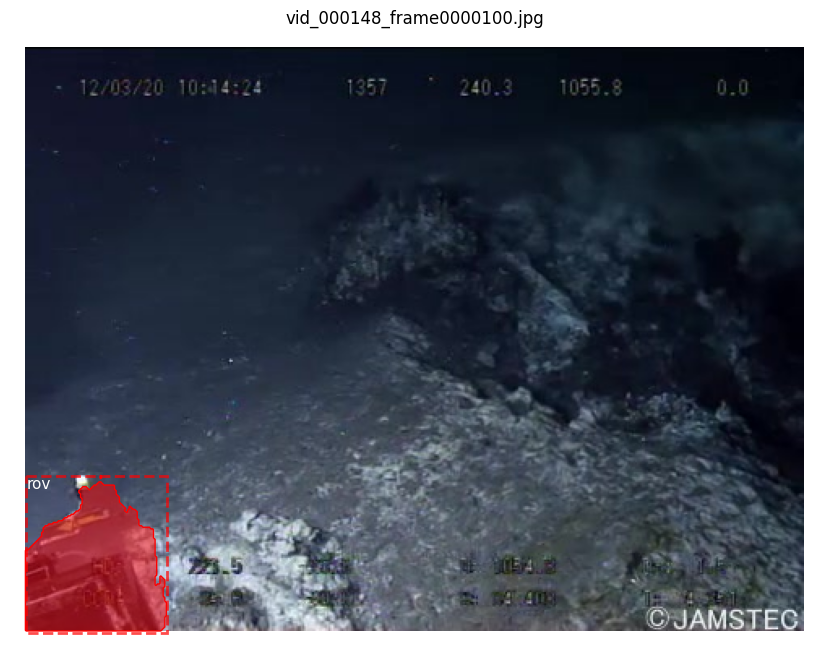

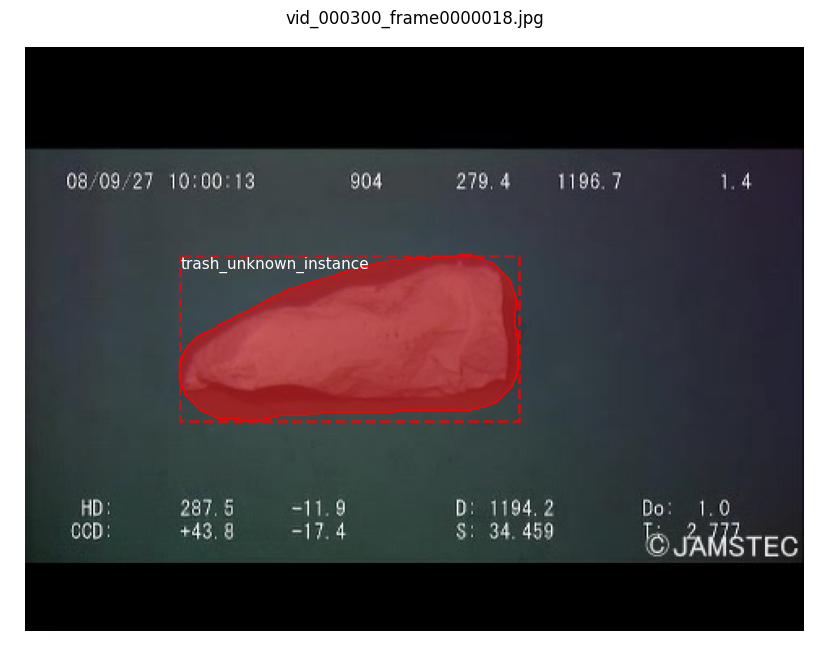

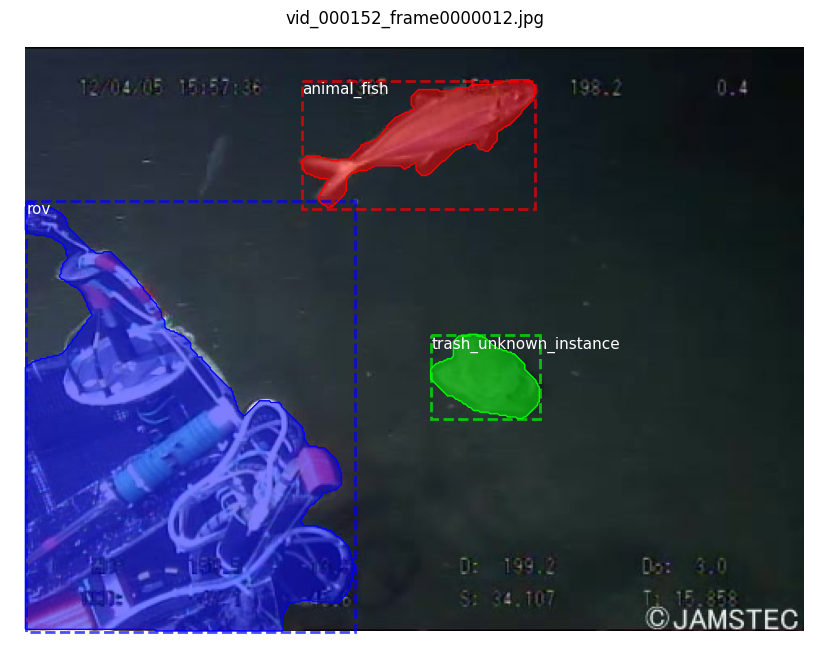

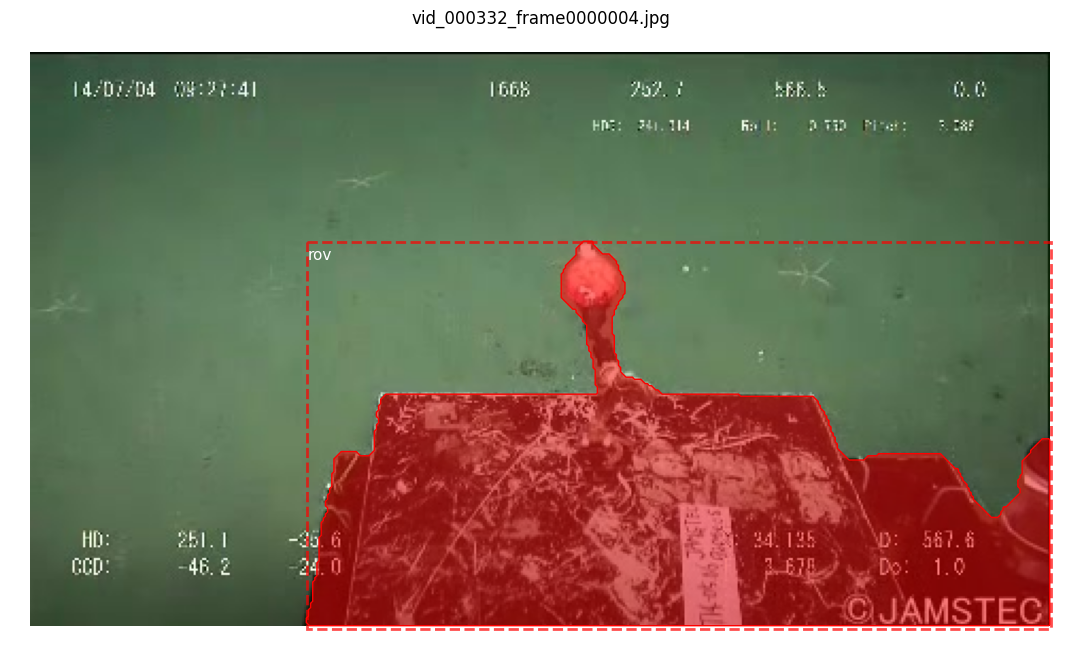

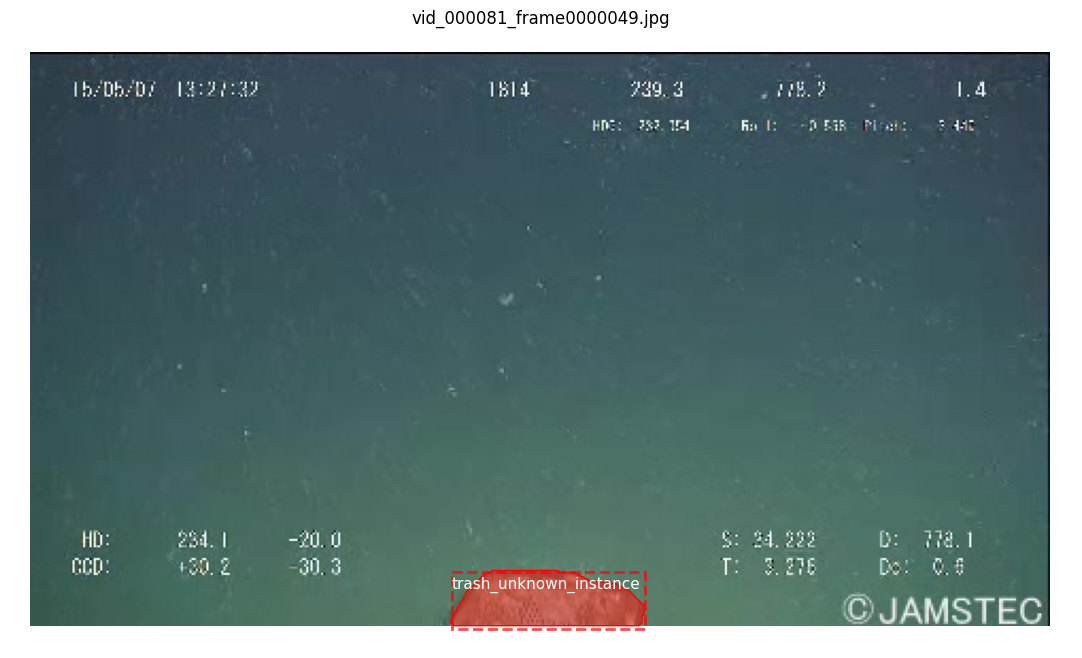

In [3]:
visualize_random_images(train_folder, num_images=5)

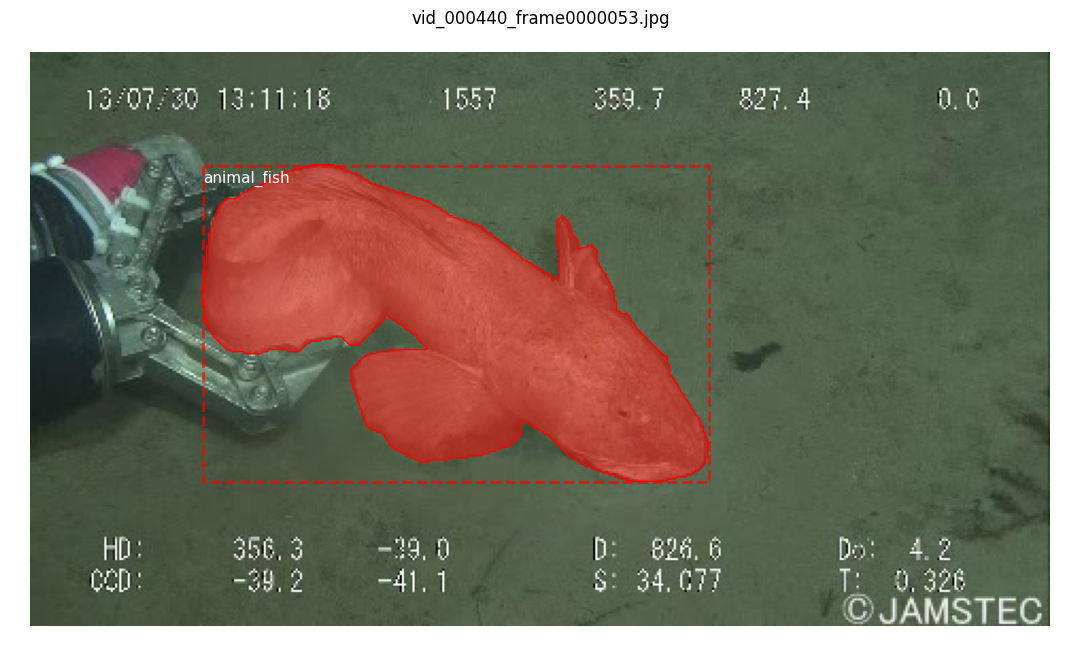

In [4]:
visualize_image_by_name('vid_000440_frame0000053.jpg')

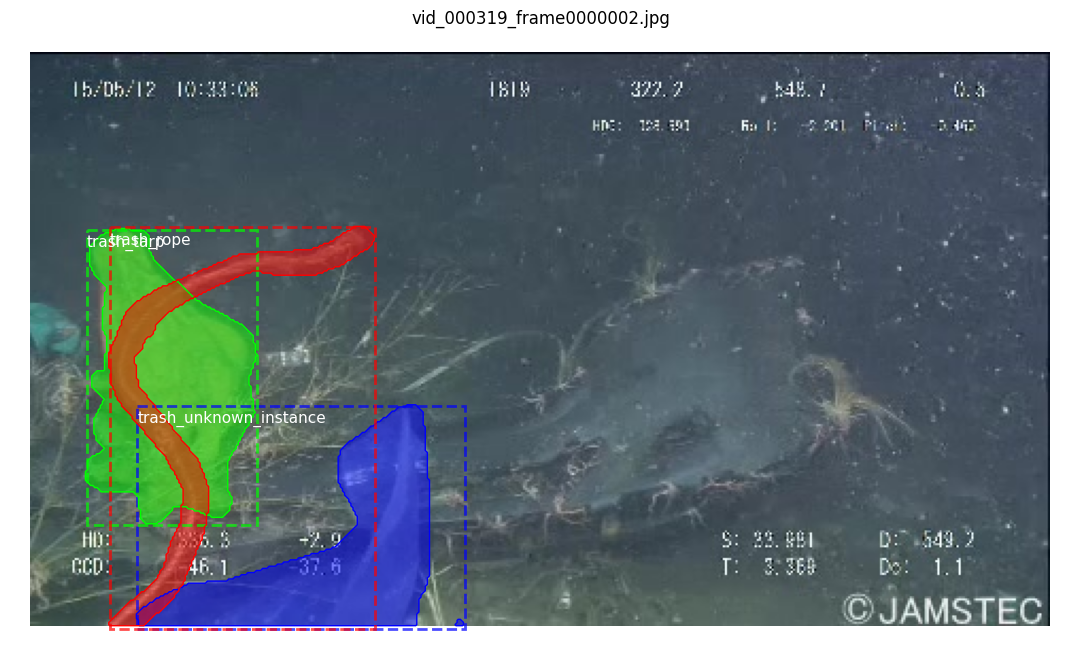

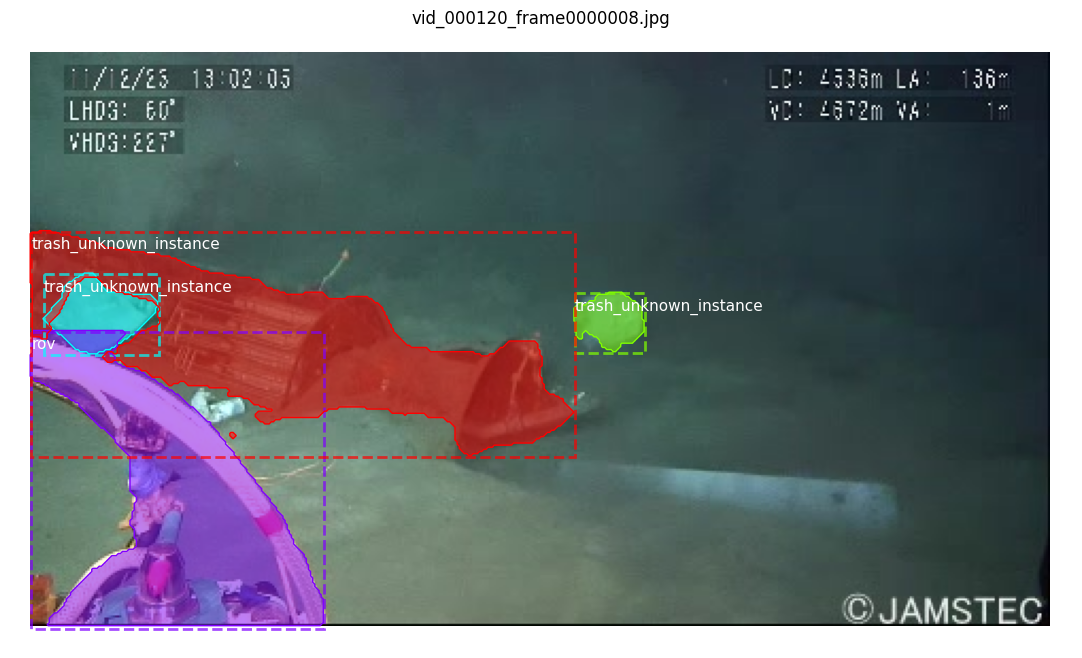

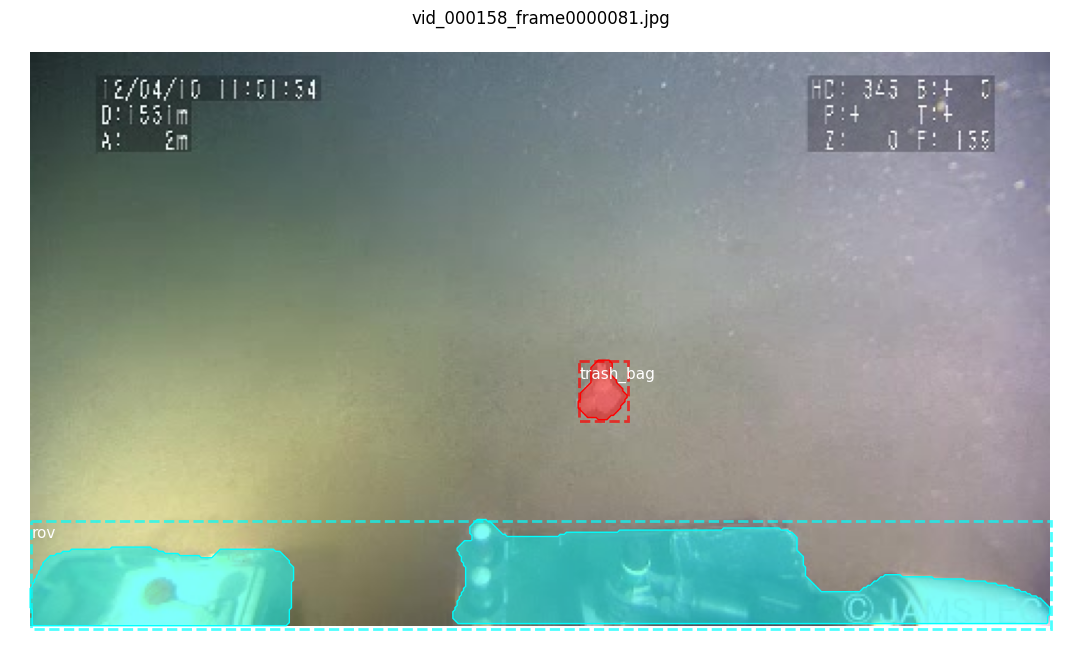

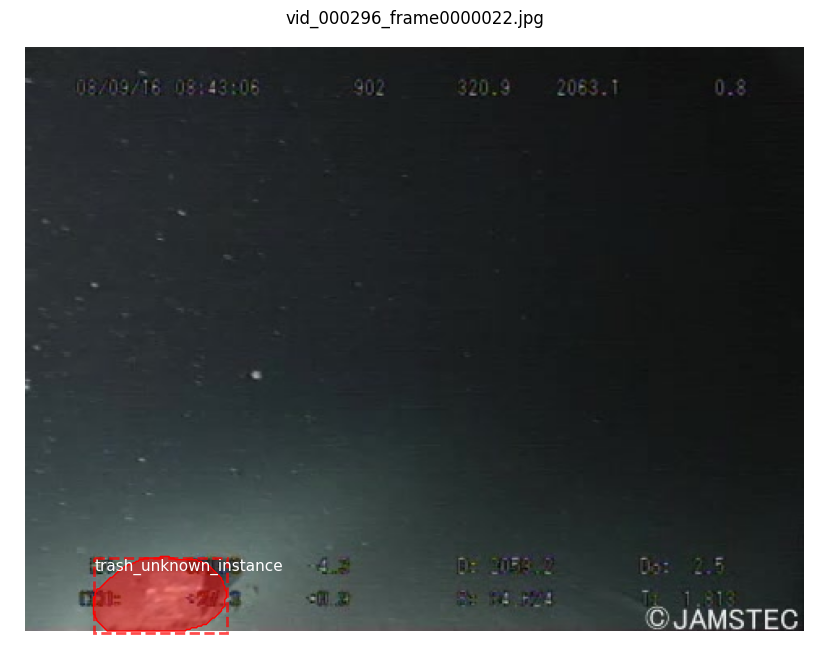

In [5]:
visualize_random_images(train_folder, num_images=5)